In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\FraudDetectionData.csv")

In [3]:
# Importing LabelEncoder from Sklearn
# library from preprocessing Module.
from sklearn.preprocessing import LabelEncoder
# Creating a instance of label Encoder.
le = LabelEncoder()
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(df['type'])
# printing label
label
# removing the column 'type' from df
# as it is of no use now.
df.drop("type", axis=1, inplace=True)
# Appending the array to our dataFrame
# with column name 'type'
df["type"] = label
# printing Dataframe
#df

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df['nameDest'])
label
df.drop("nameDest", axis=1, inplace=True)
df["nameDest"] = label
#df

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df['nameOrig'])
label
df.drop("nameOrig", axis=1, inplace=True)
df["nameOrig"] = label
#df

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop('isFraud', axis=1)
# Separate the target variable
y = df['isFraud']

# Print class distribution before split
print(y.value_counts(normalize=True))

from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=18)

# Print class distribution after split
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.998709
1    0.001291
Name: isFraud, dtype: float64
0    0.998709
1    0.001291
Name: isFraud, dtype: float64
0    0.99871
1    0.00129
Name: isFraud, dtype: float64


In [7]:
import random
random.seed (20)
import numpy as np
from scipy import stats

# Specify columns with outliers
cols_with_outliers = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Specify the number of bootstrapped samples to create per column
num_samples = 50

# Specify the right trimming proportions for each column
trim_props = {'amount': 0.14, 'oldbalanceOrg': 0.24, 'newbalanceOrig': 0.25, 'oldbalanceDest': 0.22, 'newbalanceDest': 0.22}

# Initialize empty dictionaries to store the trimmed means for each column
train_trimmed_means = {}

# Loop over the specified columns
for col_name in cols_with_outliers:
    
    # Check if the trimming proportion for this column is 0
    if trim_props[col_name] == 0:
        # If so, skip this column and move on to the next one
        continue
    
    # Initialize empty lists to store the bootstrapped samples and the trimmed means for the training set
    train_bootstrapped_samples = []
    train_trimmed_means_list = []
    
    # Loop over the number of desired samples
    for i in range(num_samples):
        # Randomly select indices from the column in the training set
        train_sample_indices = np.random.choice(X_train.index, size=len(X_train), replace=True)
        
        # Create a bootstrapped sample by indexing into the column with the selected indices for the training set
        train_sample = X_train.loc[train_sample_indices, col_name]
        
        # Append the bootstrapped samples to the list for the training set
        train_bootstrapped_samples.append(train_sample)
        
        # Calculate the right trimmed mean of the bootstrapped sample for the training set
        train_right_trimmed_mean = np.mean(train_sample[train_sample <= np.percentile(train_sample, 100*(1-trim_props[col_name]))])
        train_trimmed_means_list.append(train_right_trimmed_mean)
        
    # Calculate the mean of the right trimmed means for the training set and add it to the dictionary
    train_trimmed_means[col_name] = np.mean(train_trimmed_means_list)

    # Replace the outliers in the training set with the trimmed means
    X_train.loc[X_train[col_name] > np.percentile(X_train[col_name], 100*(1-trim_props[col_name])), col_name] = train_trimmed_means[col_name]

# Print the trimmed means for each column separately for the training set
print("Train set trimmed means: ", train_trimmed_means)

Train set trimmed means:  {'amount': 84277.48698369777, 'oldbalanceOrg': 17615.975719660066, 'newbalanceOrig': 12168.5707546509, 'oldbalanceDest': 191025.89008494822, 'newbalanceDest': 245126.72381359068}


In [8]:
# Convert float64 columns to float32
float64_cols = df.select_dtypes(include=['float64']).columns
df[float64_cols] = df[float64_cols].astype('float32')

## FS Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
# Select top features using Random Forest
rf = RandomForestClassifier(random_state=18)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = X_train.columns[indices][:5]  # select top 5 features
print(top_features )

Index(['newbalanceDest', 'step', 'oldbalanceOrg'], dtype='object')


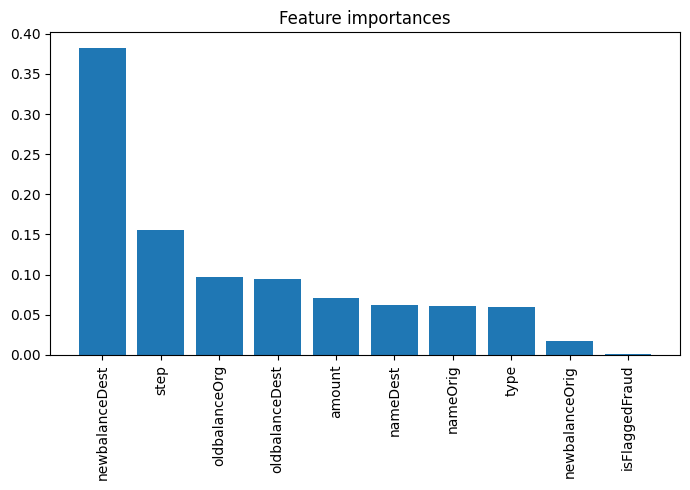

In [10]:
import matplotlib.pyplot as plt
# Plot feature importances
plt.figure(figsize=(7, 5))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

In [11]:
# Subset X_train to include only selected features
X_train_selected = X_train[top_features]

## Tuning with selected features

In [12]:
# param_grid = { 
#     'n_estimators': [100,300],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [3,4,5],
#     'criterion' :['gini', 'entropy']
# }

In [13]:
# from sklearn.model_selection import GridSearchCV

In [14]:
# clf = GridSearchCV(rf, param_grid = param_grid, cv = 3, verbose=True)

In [15]:
# best_clf = clf.fit(X_train_selected,y_train)

In [ ]:
# print (f'Accuracy - : {best_clf.score(X,y):.3f}')

## New- RandomizedSearchCV

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [18]:
# Define your hyperparameter search space
param_dist = { 
    'n_estimators': sp_randint(100, 300),
    'max_features': ['sqrt', 'log2'],
    'max_depth' : sp_randint(3,5),
    'criterion' :['gini', 'entropy']
}

In [19]:
clf = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, cv=3, verbose=2, random_state=18)
best_clf = clf.fit(X_train_selected, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=169; total time=12.4min
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=169; total time= 9.7min
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=169; total time= 9.7min
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=166; total time=10.5min
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=166; total time= 9.9min
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=166; total time=10.1min
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=245; total time=10.3min
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=245; total time=17.7min
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=245; total time=13.9min
[CV] END criterion=entropy, max_depth=4, max_features=log2, n_estimators=290; total time=22.4m

In [29]:
#Extract same features in test set,select the columns by index
selected_indices = [5,0,2]
X_test_selected = X_test.iloc[:, selected_indices]

In [30]:
print(X_test_selected.shape)

(636262, 3)


In [31]:
X_test_selected

,newbalanceDest,step,oldbalanceOrg
1402687,323930.00,139,2080.00
2760752,97668.37,213,5854688.09
3594236,0.00,262,274516.76
1933631,0.00,177,70800.94
2227203,4123295.63,186,0.00
...,...,...,...
3753638,0.00,279,0.00
1532557,0.00,154,1235072.75
2800777,0.00,217,12915.80
2444235,0.00,203,271067.00


In [32]:
X_train_selected

,newbalanceDest,step,oldbalanceOrg
5289717,6.115774e+05,373,3296.00000
5962343,0.000000e+00,406,0.00000
2527894,0.000000e+00,205,10548.00000
4081906,1.050114e+06,301,0.00000
5004020,2.451267e+05,353,0.00000
...,...,...,...
3873820,1.335741e+05,283,29907.00000
713223,2.451267e+05,37,231.00000
4991147,2.451267e+05,352,29582.00000
6279815,2.451267e+05,644,17615.97572


In [33]:
print (f'Accuracy - : {best_clf.score(X_test_selected,y_test):.3f}')

Accuracy - : 0.999


## Use cost sensitive learning random forest with the hyperparameters

Cost sensitive learning
Use correct hyperparameter
plot OOB error for every fold
plot f1 score for train & test : https://www.bing.com/images/search?view=detailV2&ccid=7RhAWIsn&id=EFDAEB69AA4818AB3C9475F012C996C507736D0B&thid=OIP.7RhAWIsn6RONqcOdAR6t6gHaHJ&mediaurl=https%3A%2F%2Fcdn.analyticsvidhya.com%2Fwp-content%2Fuploads%2F2020%2F03%2FScreenshot-2020-03-04-at-15.08.50-850x820.png&cdnurl=https%3A%2F%2Fth.bing.com%2Fth%2Fid%2FR.ed1840588b27e9138da9c39d011eadea%3Frik%3DC21zB8WWyRLwdQ%26pid%3DImgRaw%26r%3D0&exph=820&expw=850&q=graphs+for+random+forest&simid=608001867482224477&form=IRPRST&ck=ACE74CE8E33F1BDCD8DFF63221C79789&selectedindex=9&ajaxhist=0&ajaxserp=0&vt=0&sim=11

out-of-sample testing" or "model validation.

https://www.bing.com/images/search?view=detailV2&ccid=HiBreHJ1&id=4AE90CD5515EF4A6E50E9C0688ACB5FE7C375F42&thid=OIP.HiBreHJ1b7h-1uQEgXJDfQHaFB&mediaurl=https%3A%2F%2Fmiro.medium.com%2Fmax%2F552%2F1*80OL6-Nn2oYwQPcS3aO3jg.png&exph=374&expw=552&q=graphs+for+random+forest&simid=608008151010657800&form=IRPRST&ck=18435DC859CC9886473DD5FB88D029A8&selectedindex=29&ajaxhist=0&ajaxserp=0&vt=0&sim=11&cdnurl=https%3A%2F%2Fth.bing.com%2Fth%2Fid%2FR.1e206b7872756fb87ed6e4048172437d%3Frik%3DQl83fP61rIgGnA%26pid%3DImgRaw%26r%3D0